In [25]:
import torch
import torchvision
import numpy as np
import cv2
import math
import sys
import time
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from tqdm import tqdm # progress bar
import pandas as pd

Детектор обучен на 2 класса "cat" и  "horse" на базе датасета pascal VOC 2007. В качестве детектора использован fasterrcnn_resnet50_fpn.

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [2]:
device = torch.device('cuda')

In [3]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self):    
        dataset_train = torchvision.datasets.VOCDetection(root="VOC", year='2007', image_set='train', download=True)
        
        self.images = []
        self.targets = []
        
        for i in range(len(dataset_train)):
            
            objects = dataset_train[i][1]['annotation']['object']
            new_objects = list(filter(lambda x: str(x['name']).lower() == 'dog' or str(x['name']).lower() == 'horse', objects))
            
            if (len(new_objects)):
                boxes = []
                labels = []
                areas = []
                iscrowd = []
                for obj in new_objects: 
                    img = np.asarray(dataset_train[i][0])
                    height, width, channels = img.shape
                    img = cv2.resize(img, (500, 300), interpolation=cv2.INTER_CUBIC)
                    img = img / 255
                    img = img.astype(np.float32)
                    img = np.moveaxis(img, 2, 0) 
                   
                    box = [float(obj['bndbox']['xmin']) / width,
                            float(obj['bndbox']['ymin']) / height,
                            float(obj['bndbox']['xmax']) / width,
                            float(obj['bndbox']['ymax']) / height]
                    
                    area = (box[3] - box[1]) * (box[2] - box[0])
                    
                    boxes.append(box)
                    areas.append(area)
                    iscrowd.append(0)
                    
                    if str(obj['name']).lower() == 'horse':
                        labels.append(1)
                    elif str(obj['name']).lower() == 'dog':
                        labels.append(2)
                
                target = {}
                target['boxes'] = torch.as_tensor(boxes, dtype=torch.float32).to(device)
                target['labels'] = torch.as_tensor(labels, dtype=torch.int64).to(device)
                target['image_id'] = torch.tensor([i]).to(device)
                target['area'] = torch.as_tensor(area, dtype=torch.float32).to(device)
                target['iscrowd'] = torch.as_tensor(iscrowd, dtype=torch.int64).to(device)
                image = torch.tensor(img).to(device)
             
                self.targets.append(target)
                self.images.append(image)
             
    def __getitem__(self, idx):
        return self.images[idx], self.targets[idx] 

    def __len__(self):
        return len(self.images)
    
class ValDataset(torch.utils.data.Dataset):
    def __init__(self):    
        dataset_val = torchvision.datasets.VOCDetection(root="VOC", year='2007', image_set='val', download=True)
        
        self.images = []
        self.targets = []
        
        for i in range(len(dataset_val)):
            
            objects = dataset_val[i][1]['annotation']['object']
            new_objects = list(filter(lambda x: str(x['name']).lower() == 'dog' or str(x['name']).lower() == 'horse', objects))
            
            if (len(new_objects)):
                boxes = []
                labels = []
                areas = []
                iscrowd = []
                for obj in new_objects: 
                    img = np.asarray(dataset_val[i][0])
                    height, width, channels = img.shape
                    img = cv2.resize(img, (500, 300), interpolation=cv2.INTER_CUBIC)
                    img = img / 255
                    img = img.astype(np.float32)
                    img = np.moveaxis(img, 2, 0) 
                   
                    box = [float(obj['bndbox']['xmin']) / width,
                            float(obj['bndbox']['ymin']) / height,
                            float(obj['bndbox']['xmax']) / width,
                            float(obj['bndbox']['ymax']) / height]
                    
                    area = (box[3] - box[1]) * (box[2] - box[0])
                    
                    boxes.append(box)
                    areas.append(area)
                    iscrowd.append(0)
                    
                    if str(obj['name']).lower() == 'horse':
                        labels.append(1)
                    elif str(obj['name']).lower() == 'dog':
                        labels.append(2)
                
                target = {}
                target['boxes'] = torch.as_tensor(boxes, dtype=torch.float32).to(device)
                target['labels'] = torch.as_tensor(labels, dtype=torch.int64).to(device)
                target['image_id'] = torch.tensor([i]).to(device)
                target['area'] = torch.as_tensor(area, dtype=torch.float32).to(device)
                target['iscrowd'] = torch.as_tensor(iscrowd, dtype=torch.int64).to(device)
                image = torch.tensor(img).to(device)
             
                self.targets.append(target)
                self.images.append(image)
             
    def __getitem__(self, idx):
        return self.images[idx], self.targets[idx] 

    def __len__(self):
        return len(self.images)

In [57]:
dataset_train = TrainDataset()
data_loader = torch.utils.data.DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=0,collate_fn=collate_fn)

Using downloaded and verified file: VOC/VOCtrainval_06-Nov-2007.tar
Extracting VOC/VOCtrainval_06-Nov-2007.tar to VOC


In [5]:
def create_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(progress=True, pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [6]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
               
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [7]:
model = create_model(num_classes=3).to(device)

In [8]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device)
num_epochs = 10

In [9]:
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch)
    lr_scheduler.step()
    
torch.save(model.state_dict(), "model.bin")

  0%|          | 0/88 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 88/88 [01:58<00:00,  1.35s/it]


Epoch 0, lr: 0.010000, loss: 0.295715, loss_classifier: 0.027493, loss_box: 0.001800, loss_rpn_box: 0.227936, loss_object: 0.038486


100%|██████████| 88/88 [02:00<00:00,  1.36s/it]


Epoch 1, lr: 0.010000, loss: 0.191582, loss_classifier: 0.011638, loss_box: 0.005087, loss_rpn_box: 0.172511, loss_object: 0.002346


100%|██████████| 88/88 [02:00<00:00,  1.37s/it]


Epoch 2, lr: 0.010000, loss: 0.172386, loss_classifier: 0.012802, loss_box: 0.006429, loss_rpn_box: 0.151086, loss_object: 0.002069


100%|██████████| 88/88 [02:00<00:00,  1.37s/it]


Epoch 3, lr: 0.010000, loss: 0.145452, loss_classifier: 0.011938, loss_box: 0.005418, loss_rpn_box: 0.126496, loss_object: 0.001599


100%|██████████| 88/88 [02:01<00:00,  1.38s/it]


Epoch 4, lr: 0.010000, loss: 0.153839, loss_classifier: 0.012295, loss_box: 0.006363, loss_rpn_box: 0.133570, loss_object: 0.001611


100%|██████████| 88/88 [02:01<00:00,  1.38s/it]


Epoch 5, lr: 0.001000, loss: 0.132438, loss_classifier: 0.015264, loss_box: 0.011318, loss_rpn_box: 0.103881, loss_object: 0.001975


100%|██████████| 88/88 [02:01<00:00,  1.38s/it]


Epoch 6, lr: 0.001000, loss: 0.130192, loss_classifier: 0.017548, loss_box: 0.015446, loss_rpn_box: 0.095890, loss_object: 0.001308


100%|██████████| 88/88 [02:01<00:00,  1.38s/it]


Epoch 7, lr: 0.001000, loss: 0.127761, loss_classifier: 0.018402, loss_box: 0.017017, loss_rpn_box: 0.091209, loss_object: 0.001133


100%|██████████| 88/88 [02:01<00:00,  1.38s/it]


Epoch 8, lr: 0.001000, loss: 0.123584, loss_classifier: 0.017157, loss_box: 0.014809, loss_rpn_box: 0.090197, loss_object: 0.001420


100%|██████████| 88/88 [02:00<00:00,  1.37s/it]


Epoch 9, lr: 0.001000, loss: 0.121587, loss_classifier: 0.017118, loss_box: 0.015151, loss_rpn_box: 0.088058, loss_object: 0.001260


In [10]:
val_dataset = ValDataset()
data_loader_test = torch.utils.data.DataLoader(
        val_dataset, batch_size=1, num_workers=0, shuffle=False, collate_fn=collate_fn
    )

Using downloaded and verified file: VOC/VOCtrainval_06-Nov-2007.tar
Extracting VOC/VOCtrainval_06-Nov-2007.tar to VOC


In [30]:
model.eval()
outputs = model([val_dataset.images[0]])

In [31]:
outputs

[{'boxes': tensor([[4.1361e-01, 2.3345e-01, 8.7276e-01, 8.3552e-01],
          [2.7771e-01, 2.5118e-01, 6.7780e-01, 7.6009e-01],
          [5.6311e-01, 2.8954e-01, 9.6897e-01, 7.8785e-01],
          [3.7246e-01, 2.8565e-01, 7.8319e-01, 8.1607e-01],
          [5.2142e-01, 1.0296e-01, 8.7514e-01, 5.5474e-01],
          [3.7101e-01, 0.0000e+00, 7.8923e-01, 2.3181e-01],
          [2.5400e-01, 0.0000e+00, 6.5898e-01, 3.7903e-01],
          [6.4175e-01, 2.2034e-01, 9.5985e-01, 6.2658e-01],
          [1.7484e-01, 2.2485e-01, 6.2655e-01, 7.9001e-01],
          [5.6278e-01, 2.9061e-01, 9.6879e-01, 7.8793e-01],
          [1.3870e-01, 3.8928e-01, 4.3959e-01, 8.1582e-01],
          [6.6500e-01, 1.4438e-01, 1.1594e+00, 7.7234e-01],
          [5.2073e-01, 1.0376e-01, 8.7446e-01, 5.5302e-01],
          [2.6164e-01, 4.6070e-01, 5.8585e-01, 9.0703e-01],
          [3.4454e-01, 0.0000e+00, 2.4658e+00, 1.7325e+00],
          [6.4143e-01, 2.2138e-01, 9.5989e-01, 6.2623e-01],
          [3.7038e-01, 0.0000e+

In [32]:
outputs[0]['labels'][outputs[0]['scores'] == max(outputs[0]['scores'])]

tensor([2], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


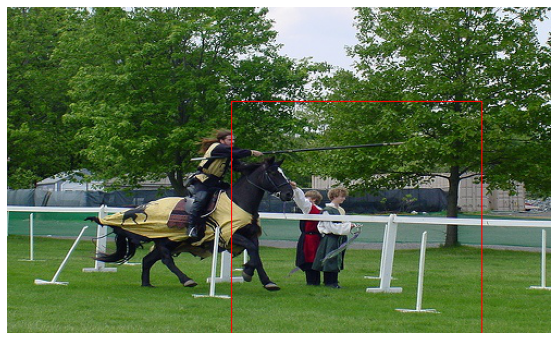

In [34]:
from matplotlib import pyplot as plt
idx = 0
sample_1 = val_dataset.images[idx].permute(1,2,0).cpu().numpy()
boxes = outputs[idx]['boxes'][outputs[idx]['scores'] >= max(outputs[idx]['scores'])].data.cpu().numpy()

fig, ax = plt.subplots(1,1, figsize=(12,6))

for box_1 in boxes:
    cv2.rectangle(sample_1, (int(box_1[0]*500), int(box_1[1]*375)), (int(box_1[2]*500), int(box_1[3]*375)), (220, 0, 0), 1)

ax.set_axis_off()
ax.imshow(sample_1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


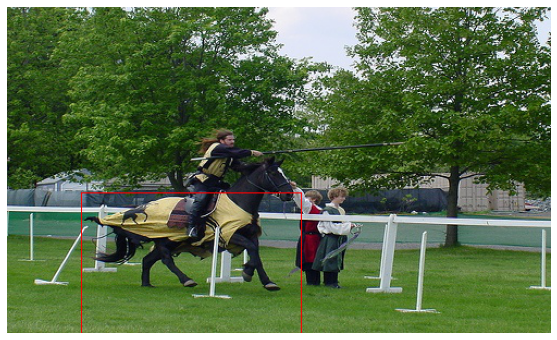

In [15]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
idx = 0
sample_1 = val_dataset.images[idx].permute(1,2,0).cpu().numpy()
boxes = val_dataset.targets[idx]['boxes'].data.cpu().numpy()
for box in boxes:
  cv2.rectangle(sample_1, (int(box[0]*500), int(box[1]*375)), (int(box[2]*500), int(box[3]*375)), (220, 0, 0), 1)

ax.set_axis_off()
ax.imshow(sample_1)

In [71]:
model.eval()
tp = 0
fp = 0
for i, img in enumerate(val_dataset.images):
    outputs = model([img])
    torch.cuda.empty_cache()
    target_label = val_dataset.__getitem__(i)[1]['labels'].cpu().numpy()
    output_label = outputs[0]['labels'][outputs[0]['scores'] == max(outputs[0]['scores'])].cpu().numpy()
    if target_label[0] == output_label[0]:
        tp+=1
    else:
        fp+=1

In [72]:
precision = tp/(tp+fp)

Точность классификации

In [73]:
round(precision, 1)

0.6